## Exercici 1
Realitza web scraping d'una pàgina de la borsa de Madrid (https://www.bolsamadrid.es) utilitzant BeautifulSoup i Selenium.

**BeautifulSoup**

In [37]:
import requests

URL = "https://www.bolsamadrid.es/esp/aspx/Mercados/Precios.aspx?indice=ESI100000000&punto=indice"
page = requests.get(URL)

print(page.text)


<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
<html xmlns="http://www.w3.org/1999/xhtml">
<head data-idioma="esp" data-hora-act="Wed, 30 Mar 2022 17:21:28 GMT" data-app-path="/" data-bolsa="BMadrid" data-analytics-id="UA-35966870-2"><meta http-equiv="X-UA-Compatible" content="IE=11" /><meta http-equiv="Content-Type" content="text/html; charset=UTF-8" /><meta id="ctl00_copyright" name="copyright" content="Copyright © BME 2022" /><title>
	Bolsa de Madrid - Precios Sesión
</title><link id="ctl00_RSSLink1" rel="alternate" type="application/rss+xml" href="/esp/aspx/RSS/RSS.ashx?feed=Todo" title="Bolsa de Madrid: Todos los contenidos agregados" /><link id="ctl00_RSSLink2" rel="alternate" type="application/rss+xml" href="/esp/aspx/RSS/RSS.ashx?feed=NotasPrensa" title="Bolsa de Madrid: Notas de Prensa" /><link id="ctl00_RSSLink3" rel="alternate" type="application/rss+xml" href="/esp/aspx/RSS/RSS.ashx?feed=Regulacion" 

In [38]:
import requests
from bs4 import BeautifulSoup

URL = "https://www.bolsamadrid.es/esp/aspx/Mercados/Precios.aspx?indice=ESI100000000&punto=indice"
page = requests.get(URL)

soup = BeautifulSoup(page.content, "html.parser")

In [39]:
empresas = soup.find_all("td", class_="DifFlBj")
difs = soup.find_all("td", class_="DifClBj")

empresas_bj = []
for empresa in empresas:
    empresas_bj.append(empresa.text.strip())

print(len(empresas_bj), empresas_bj)

difs_bj = []
for dif in difs:
    difs_bj.append(dif.text.strip())
    
print(len(difs_bj), difs_bj)

19 ['IBEX 35®', 'ACERINOX', 'ACS', 'AMADEUS', 'ARCELORMIT.', 'B.SANTANDER', 'BA.SABADELL', 'BANKINTER', 'BBVA', 'CAIXABANK', 'CIE AUTOMOT.', 'FERROVIAL', 'FLUIDRA', 'IAG', 'IBERDROLA', 'INDITEX', 'MAPFRE', 'MELIA HOTELS', 'MERLIN']
20 ['-0,85', '-1,98', '-1,66', '-0,96', '-1,94', '-1,10', '-3,37', '-1,71', '-0,55', '-2,27', '-1,01', '-1,31', '-2,36', '-3,06', '-3,14', '-0,60', '-2,40', '-1,04', '-1,18', '-0,05']


In [40]:
empresas = soup.find_all("td", class_="DifFlSb")
difs = soup.find_all("td", class_="DifClSb")

empresas_sb = []
for empresa in empresas:
    empresas_sb.append(empresa.text.strip())

print(len(empresas_sb), empresas_sb)

difs_sb = []
for dif in difs:
    difs_sb.append(dif.text.strip())
    
print(len(difs_sb), difs_sb)

17 ['ACCIONA', 'AENA', 'ALMIRALL', 'CELLNEX', 'ENAGAS', 'ENDESA', 'GRIFOLS CL.A', 'INDRA A', 'INM.COLONIAL', 'NATURGY', 'PHARMA MAR', 'R.E.C.', 'REPSOL', 'ROVI', 'SIEMENS GAME', 'SOLARIA', 'TELEFONICA']
17 ['0,18', '0,47', '1,62', '0,86', '0,53', '0,70', '7,33', '0,68', '0,54', '2,10', '3,52', '1,90', '2,09', '0,44', '2,88', '7,38', '0,88']


In [41]:
# Averiguar si el IBEX ha subido o ha bajado
if "IBEX 35®" in empresas_sb:
    print(empresas_sb)
    index = empresas_sb.index("IBEX 35®")
    del empresas_sb[index]
    print(empresas_sb)
elif "IBEX 35®" in empresas_bj:
    print(empresas_bj)
    index = empresas_bj.index("IBEX 35®")
    del empresas_sb[index]
    print(empresas_bj)

['IBEX 35®', 'ACERINOX', 'ACS', 'AMADEUS', 'ARCELORMIT.', 'B.SANTANDER', 'BA.SABADELL', 'BANKINTER', 'BBVA', 'CAIXABANK', 'CIE AUTOMOT.', 'FERROVIAL', 'FLUIDRA', 'IAG', 'IBERDROLA', 'INDITEX', 'MAPFRE', 'MELIA HOTELS', 'MERLIN']
['IBEX 35®', 'ACERINOX', 'ACS', 'AMADEUS', 'ARCELORMIT.', 'B.SANTANDER', 'BA.SABADELL', 'BANKINTER', 'BBVA', 'CAIXABANK', 'CIE AUTOMOT.', 'FERROVIAL', 'FLUIDRA', 'IAG', 'IBERDROLA', 'INDITEX', 'MAPFRE', 'MELIA HOTELS', 'MERLIN']


In [42]:
if len(empresas_sb) < len(difs_sb):
    del difs_sb[0]
    
print(len(empresas_sb), len(difs_sb))

16 16


In [43]:
if len(empresas_bj) < len(difs_bj):
    del difs_bj[0]
    
print(len(empresas_bj), len(difs_bj))

19 19


In [44]:
import pandas as pd

cambios_ibex = pd.DataFrame()

cambios_ibex["Empresa"] = empresas_bj + empresas_sb
cambios_ibex["Dif"] = difs_bj + difs_sb
cambios_ibex = cambios_ibex.sort_values(by=['Empresa'])

display(cambios_ibex)

,Empresa,Dif
1,ACERINOX,"-1,66"
2,ACS,"-0,96"
19,AENA,"0,47"
20,ALMIRALL,"1,62"
3,AMADEUS,"-1,94"
4,ARCELORMIT.,"-1,10"
5,B.SANTANDER,"-3,37"
6,BA.SABADELL,"-1,71"
7,BANKINTER,"-0,55"
8,BBVA,"-2,27"


In [45]:
cambios_ibex['Dif'] = cambios_ibex['Dif'].str.replace(',','.')
cambios_ibex['Dif'] = pd.to_numeric(cambios_ibex['Dif'])
cambios_ibex.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35 entries, 1 to 34
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Empresa  35 non-null     object 
 1   Dif      35 non-null     float64
dtypes: float64(1), object(1)
memory usage: 840.0+ bytes


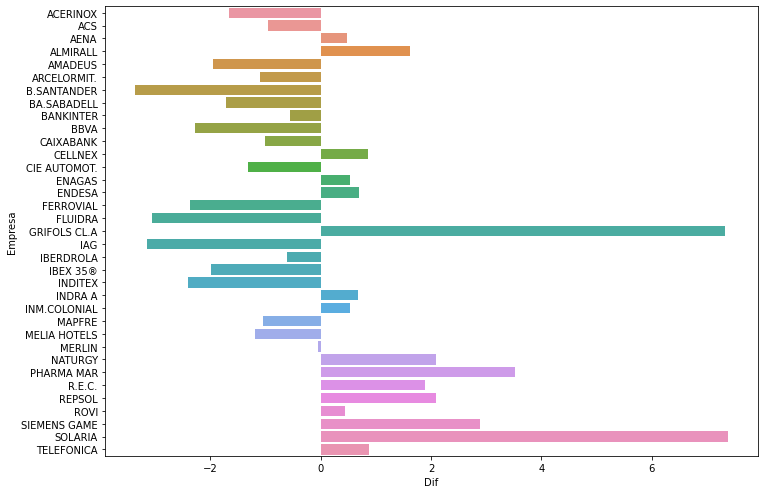

In [46]:
from matplotlib import pyplot as plt
import seaborn

a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
seaborn.barplot(x="Dif", y="Empresa", data=cambios_ibex)
plt.show()

**Selenium**

In [83]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from time import sleep


BOLSA_PRECIOSIBEX ='https://www.bolsamadrid.es/esp/aspx/Mercados/Precios.aspx?indice=ESI100000000&punto=indice'

class PreciosIbex():
    def __init__(self):
        # Create a headless browser
        options = webdriver.ChromeOptions()
        options.add_argument("--start-maximized")
        options.add_argument('--log-level=3')
        options.add_argument('--headless')

        self.driver = webdriver.Chrome(
            executable_path="chromedriver",
            options=options
        )
        self.driver.get(BOLSA_PRECIOSIBEX)

        self._current_track_number = 1
        self.empresas_sb = []
        self.empresas_bj = []
        self.difs_sb = []
        self.difs_bj = []
        self.datos()
        
        self.driver.quit()

        
    def datos(self):
        '''
        Recabar información de la página relativa a cambios en el IBEX
        '''

        # Sleep para dar tiempo a la página para cargar
        sleep(1)

        empresas_sb = self.driver.find_elements(By.CLASS_NAME,'DifFlSb')
        empresas_bj = self.driver.find_elements(By.CLASS_NAME,'DifFlBj')
        difs_sb = self.driver.find_elements(By.CLASS_NAME,'DifClSb')
        difs_bj = self.driver.find_elements(By.CLASS_NAME,'DifClBj')
        
        self.empresas_sb = [i for i in empresas_sb]
        self.empresas_bj = [i for i in empresas_bj]
        self.difs_sb = [i for i in difs_sb]
        self.difs_bj = [i for i in difs_bj]
        
        self.eliminar_info_gral_IBEX()
        self.crear_tabla()
    
    
    def eliminar_info_gral_IBEX(self):
                
        if "IBEX 35®" in self.empresas_sb:
            index = self.empresas_sb.index("IBEX 35®")
            del self.empresas_sb[index]
        elif "IBEX 35®" in self.empresas_bj:
            index = self.empresas_bj.index("IBEX 35®")
            del self.empresas_sb[index]
            

        if len(self.empresas_sb) < len(self.difs_sb):
            del self.difs_sb[0]

        if len(self.empresas_bj) < len(self.difs_bj):
            del self.difs_bj[0]
        
        
    def crear_tabla(self):
        cambios_ibex = pd.DataFrame()
        cambios_ibex["Empresa"] = self.empresas_bj + self.empresas_sb
        cambios_ibex["Dif"] = self.difs_bj + self.difs_sb
        cambios_ibex['Dif'] = cambios_ibex['Dif'].str.replace(',','.')
        cambios_ibex['Dif'] = pd.to_numeric(cambios_ibex['Dif'])
        
        
    def ver_grafico(self):
        self.crear_tabla()
        a4_dims = (11.7, 8.27)
        fig, ax = pyplot.subplots(figsize=a4_dims)
        seaborn.barplot(x="Dif", y="Empresa", data=cambios_ibex)
        
    
    def ver_datos(self):
        self.crear_tabla()
        display(cambios_ibex)
    

In [84]:
precios_ibex = PreciosIbex()

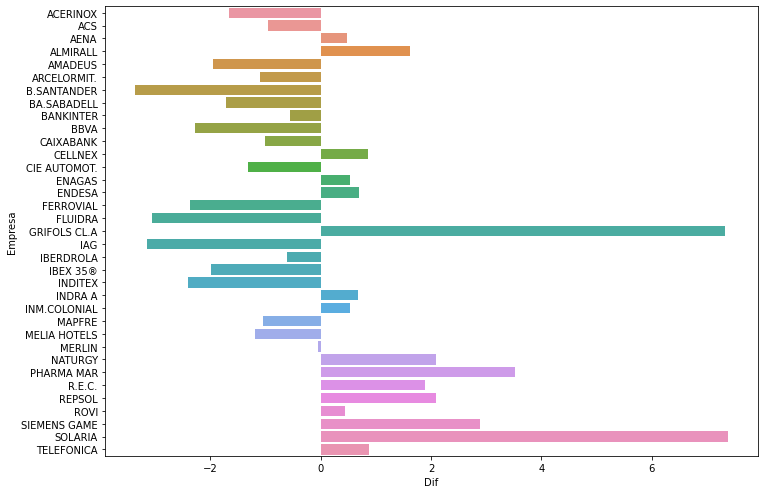

In [85]:
precios_ibex.ver_grafico()

In [86]:
precios_ibex.ver_datos()

,Empresa,Dif
1,ACERINOX,-1.66
2,ACS,-0.96
19,AENA,0.47
20,ALMIRALL,1.62
3,AMADEUS,-1.94
4,ARCELORMIT.,-1.10
5,B.SANTANDER,-3.37
6,BA.SABADELL,-1.71
7,BANKINTER,-0.55
8,BBVA,-2.27
